In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from collections import Counter

from pymatgen.core import Structure, Lattice
from pymatgen.io.vasp import Poscar

from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe
from polyhedral_analysis.octahedral_analysis import opposite_vertex_pairs

from bsym.interface.pymatgen import unique_structure_substitutions

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

from figure_formatting import figure_formatting as ff
ff.formatting['axes.linewidth'] = 0.5
ff.formatting['lines.linewidth'] = 1.0
ff.set_formatting()

In [2]:
colors = {'blue': '#264653',
          'bluegreen': '#287271',
          'green': '#2A9D8F',
          'yellow': '#E9C46A',
          'light orange': '#F4A261',
          'dark orange': '#E76F51'}

In [3]:
recipe = PolyhedraRecipe(method='distance cutoff', 
                         coordination_cutoff=3.0, 
                         central_atoms='Ti',
                         vertex_atoms=['O','F'])

In [4]:
class Config():
    
    def __init__(self,
                 structure: Structure,
                 config_id: int,
                 energy: float,
                 degeneracy: int) -> None:
        self.structure = structure
        self.config_id = config_id
        self.energy = energy
        self.degeneracy = degeneracy
        self.config = Configuration(structure=structure, recipes=[recipe])
        
    def n_non_f4o2(self) -> int:
        count = 0
        for p in self.config.polyhedra:
            coord_count = Counter([v.label for v in p.vertices])
            if coord_count['F'] != 4:
                count += 1
        return count
    
    def n_collinear_oxygen(self) -> int:
        count = 0
        for p in self.config.polyhedra:
            vertex_pairs = opposite_vertex_pairs(p, check=False)
            for vp in vertex_pairs:
                if set([vp[0].label, vp[1].label]) == {'O'}:
                    count += 1
        return count
    
    def bond_lengths(self) -> list[float]:
        distances = {'O': [], 'F': []}
        for p in self.config.polyhedra:
            for d, l in p.vertex_distances_and_labels():
                distances[l].append( d )
        return distances

In [5]:
data = pd.read_csv('../Data/energies.out',
                   delim_whitespace=True,
                   names=['config_id', 'ce_energy', 'dft_energy'],
                   na_values="None")
data.sort_values('config_id',
                 inplace=True)
data.ce_energy -= data.ce_energy.min()
data.dft_energy
data

,config_id,ce_energy,dft_energy
300,0,2.21448,-211.569551
2583,1,2.66760,-211.109399
2641,2,2.17216,-211.765435
1846,3,4.29128,-209.221864
254,4,3.02408,-210.189123
...,...,...,...
2616,2659,3.80192,NaN
1528,2660,0.43616,NaN
906,2661,0.66352,NaN
2547,2662,0.34864,NaN


In [6]:
# regenerate all 2x2x2 configs so that we have their degeneracies
a = 3.798 # lattice parameter
poscar_dir = '../Data/poscars'

# construct a ReO3 conventional unit cell as a pymatgen structure
coords = np.array([[0.0, 0.0, 0.0],
                   [0.5, 0.0, 0.0],
                   [0.0, 0.5, 0.0],
                   [0.0, 0.0, 0.5]])
atom_list = ['Ti', 'X', 'X', 'X']
lattice = Lattice.from_parameters(a=a, b=a, c=a, alpha=90, beta=90, gamma=90)
unit_cell = Structure(lattice, atom_list, coords)

# generate all symmetry-inequivalent 2x2x2 TiOF2 supercells.
parent_structure = unit_cell * [2, 2, 2]
unique_structures = unique_structure_substitutions(parent_structure, 'X', {'F':16, 'O':8})
print("Found {} unique structures".format(len(unique_structures)))

Found 2664 unique structures


In [7]:
configs = []
for i in tqdm(range(2664)):
    structure = Poscar.from_file(f'{poscar_dir}/config_{i:04d}.poscar').structure
    configs.append(Config(structure=structure,
                          config_id=i,
                          energy=data.iloc[i].ce_energy,
                          degeneracy=unique_structures[i].number_of_equivalent_configurations))

100%|██████████████████████████████████████████████████████████████████████| 2664/2664 [00:08<00:00, 322.97it/s]


In [8]:
e_range = np.linspace(0, 8, 1000)
bandwidth = 0.15
degeneracies = list(map(lambda i: configs[i].degeneracy, data.config_id.values))

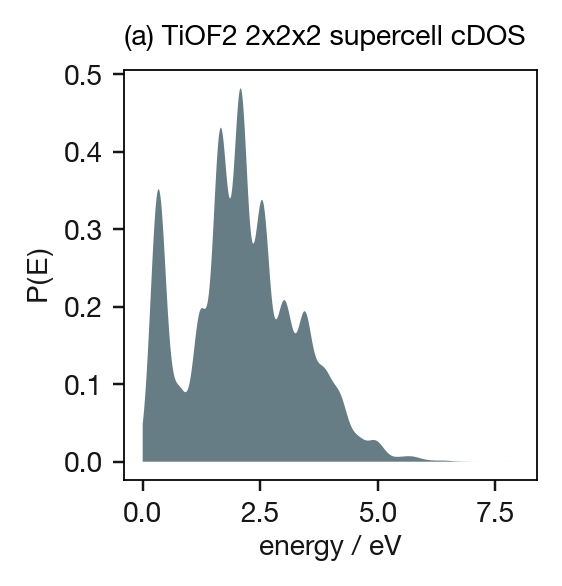

In [9]:
# panel (a)
plt.figure(figsize=[2.1, 2.1])
kde = gaussian_kde(dataset=data.ce_energy,
                   bw_method=bandwidth / data.ce_energy.std(ddof=1),
                   weights=degeneracies)
e_range = np.linspace(0, 8, 1000)
plt.fill_between(e_range, kde(e_range), color=colors['blue'], alpha=0.7, edgecolor=None)
# plt.hist(data.ce_energy, bins=100, color=colors['green'], density=True)
plt.title("(a) TiOF2 2x2x2 supercell cDOS")
plt.ylabel('$P(E)$')
plt.xlabel('energy / eV')
plt.savefig('../Figures/TiOF2_222_cDOS.pdf', dpi=300)
plt.show()

In [10]:
# panel (b) Energy vs. n collinear O–Ti–O
configs_by_n_collinear_oxygen = {0: [], 2: [], 4: [], 6: [], 8: []}
for c in tqdm(configs):
    configs_by_n_collinear_oxygen[c.n_collinear_oxygen()].append(c)

100%|██████████████████████████████████████████████████████████████████████| 2664/2664 [00:19<00:00, 133.87it/s]


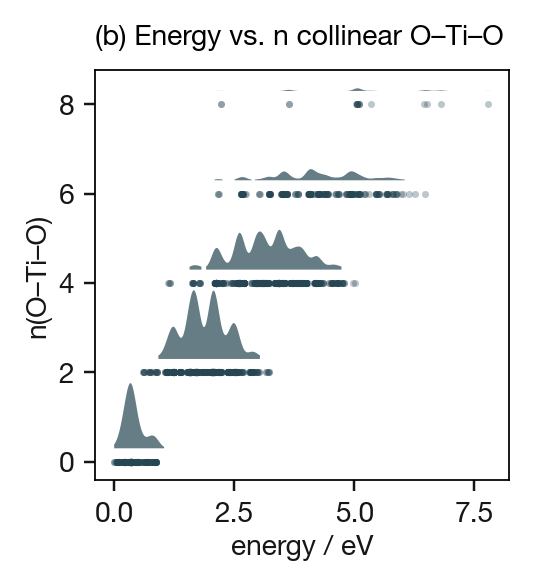

In [11]:
plt.figure(figsize=[2.1, 2.1])
kde_vscale = 0.0014
baseline_offset = 0.3
kde_threshold = 0.05

for n, these_configs in configs_by_n_collinear_oxygen.items():
    energies = np.array([c.energy for c in these_configs])
    degeneracies = np.array([c.degeneracy for c in these_configs])
    plt.plot(energies, np.full_like(energies, n),
             'o',
             color=colors['blue'],
             markersize=2,
             alpha=0.3, markeredgecolor=None, markeredgewidth=0.0)
    kde = gaussian_kde(dataset=energies,
                       bw_method=0.1 / energies.std(ddof=1),
                       weights=degeneracies)
    baseline = n + baseline_offset
    # x_loc = np.where(kde(e_range) > 0)
    plt.fill_between(e_range, kde(e_range)*kde_vscale*energies.size + baseline, baseline,
                     color=colors['blue'],
                     where=kde(e_range)>kde_threshold, interpolate=False, linewidth=0.5, alpha=0.7, edgecolor=None)
    
plt.title("(b) Energy vs. n collinear O–Ti–O")
plt.ylabel('n(O–Ti–O)')
plt.xlabel('energy / eV')
plt.savefig('../Figures/TiOF2_n_collinear.pdf', dpi=300)
plt.show()

In [12]:
import os
# Read in the DFT-optimised structures.
dft_configs = []
for i in tqdm(range(2664)):
    filename = f'../Data/dft_poscars/config_{i:04d}.POSCAR'
    if os.path.isfile(filename):
        structure = Poscar.from_file(f'../Data/dft_poscars/config_{i:04d}.POSCAR').structure
        energy = data.iloc[i].dft_energy - data.dft_energy.min()
        dft_configs.append(Config(structure, i, energy,
                                  degeneracy=unique_structures[i].number_of_equivalent_configurations))
print('Read {} POSCAR files'.format(len(dft_configs)))

100%|████████████████████████████████████████████████████████████████████| 2664/2664 [00:00<00:00, 40263.58it/s]

Read 65 POSCAR files


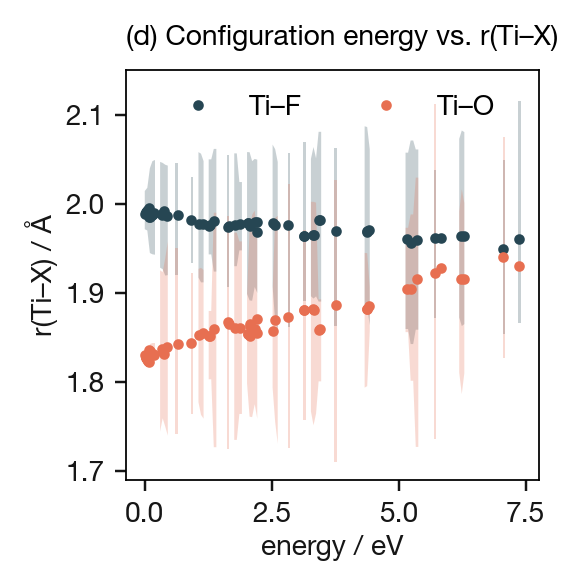

In [13]:
# panel (d): Ti–X bond lengths vs. DFT configuration energy
plt.figure(figsize=[2.1, 2.1])
markersize = 2
O_color = colors['dark orange']
F_color = colors['blue']

tif_distances_95 = []
tio_distances_95 = []
tif_distances_5 = []
tio_distances_5 = []

window_width = 0.1
e_range = np.linspace(0.0, 7.5, 150)
e_range_to_plot = []
for e in e_range:
    windowed_configs = [c for c in dft_configs
                        if (c.energy > e - window_width/2) and
                           (c.energy < e + window_width/2)]
    tif_distances_at_e = []
    tio_distances_at_e = []
    for c in windowed_configs:
        bond_lengths = c.bond_lengths()
        tif_distances_at_e.extend(bond_lengths['F'])
        tio_distances_at_e.extend(bond_lengths['O'])
    if windowed_configs:
        tif_distances_95.append(np.percentile(tif_distances_at_e, 95.0))
        tio_distances_95.append(np.percentile(tio_distances_at_e, 95.0))
        tif_distances_5.append(np.percentile(tif_distances_at_e, 5.0))
        tio_distances_5.append(np.percentile(tio_distances_at_e, 5.0))
    else:
        tif_distances_5.append(np.nan)
        tio_distances_5.append(np.nan)
        tif_distances_95.append(np.nan)
        tio_distances_95.append(np.nan)

plt.fill_between(e_range, tif_distances_5, tif_distances_95, interpolate=True, alpha=0.25, color=F_color, edgecolor=None)
plt.fill_between(e_range, tio_distances_5, tio_distances_95, interpolate=True, alpha=0.25, color=O_color, edgecolor=None)

# energies = []
mean_tif_distances = []
mean_tio_distances = []
energies = []
for c in dft_configs:
    energies.append(c.energy)
    bond_lengths = c.bond_lengths()
    mean_tif_distances.append(np.mean(bond_lengths['F']))
    mean_tio_distances.append(np.mean(bond_lengths['O']))

plt.plot(energies, mean_tif_distances, 'o', color=F_color, markersize=markersize, label="Ti–F")
plt.plot(energies, mean_tio_distances, 'o', color=O_color, markersize=markersize, label="Ti–O")

plt.title("(d) Configuration energy vs. r(Ti–X)")
plt.xlabel("energy / eV")
plt.ylabel("r(Ti–X) / Å")
plt.legend(loc='upper center', ncol=2)
plt.savefig('../Figures/TiOF2_bond_lengths.pdf', dpi=300)
plt.show()

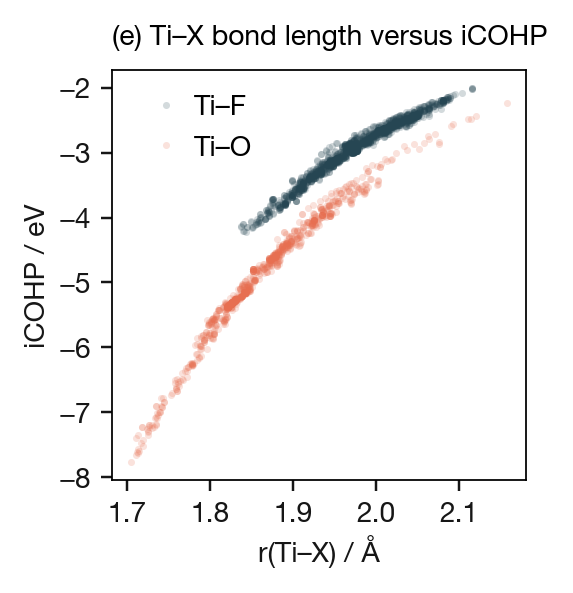

In [14]:
# panel (e): iCOHP versus bond length

icohp_data = pd.read_csv("../Data/bl_and_icohp.csv")
plt.figure(figsize=(2.1, 2.1))
icohp_F_data = icohp_data[icohp_data.anion == 'F']
icohp_O_data = icohp_data[icohp_data.anion == 'O']
plt.plot(icohp_F_data['bond length'], icohp_F_data['icohp'], 'o', label="Ti–F", markersize=markersize, markeredgecolor=None, markeredgewidth=0.0, color=F_color, alpha=0.2)
plt.plot(icohp_O_data['bond length'], icohp_O_data['icohp'], 'o', label="Ti–O", markersize=markersize, markeredgecolor=None, markeredgewidth=0.0, color=O_color, alpha=0.2)
plt.xlabel("r(Ti–X) / Å")
plt.ylabel("iCOHP / eV")
plt.xticks([1.7, 1.8, 1.9, 2.0, 2.1])
plt.title("(e) Ti–X bond length versus iCOHP")
plt.legend(handletextpad=0.01)
plt.savefig('../Figures/TiOF2_bond_lengths_vs_iCOHP.pdf', dpi=300)
plt.show()

In [15]:
sorted_configs = sorted(configs, key=lambda x: x.energy)
[c.config_id for c in sorted_configs[0:3]]

[253, 255, 281]

In [16]:
sorted_configs[2].energy

0.01168000000001257